<a href="https://colab.research.google.com/github/paviayyala/AIML-Lab/blob/main/What_IF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Shape: (1000, 10)

Baseline Revenue: 2321927.74
Baseline Profit: 682309.98


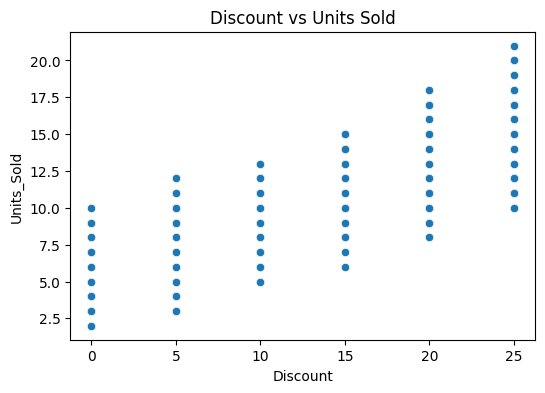


Customer Segments Distribution:
Segment
1    100
0     89
3     88
2     84
Name: count, dtype: int64

Discount Impact Coefficient: 0.3755

Scenario (+10% discount) Profit: 592531.55

Optimal Discount Policy per Segment:
{np.int32(1): 0, np.int32(2): 0, np.int32(3): 0, np.int32(0): 0}

DONE – End-to-End Sales Optimization Completed


In [1]:
# ============================================================
# DATA-DRIVEN SALES OPTIMIZATION – FULL PIPELINE (ONE CELL)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

np.random.seed(42)

# ============================================================
# 1. SYNTHETIC DATA GENERATION
# ============================================================

n = 1000

customers = np.random.randint(1, 401, n)
ages = np.clip(np.random.normal(35, 10, n),18,75).astype(int)
income = np.clip(np.random.normal(50000, 20000, n),10000,200000)
loyalty = np.clip(np.random.normal(5, 2, n), 1, 10)
discount = np.random.choice([0,5,10,15,20,25], n)
price = np.random.uniform(50, 500, n)
season_multiplier = np.random.choice([0.9, 1.0, 1.2, 1.3], n)

units = (5 + 0.35*discount - 0.00002*income + 0.25*loyalty) * season_multiplier
units = np.maximum(1, units + np.random.normal(0,1,n)).astype(int)

revenue = units * price * (1 - discount/100)
cost = units * price * 0.6
profit = revenue - cost

df = pd.DataFrame({
    "Customer_ID": customers,
    "Age": ages,
    "Income": income,
    "Loyalty": loyalty,
    "Discount": discount,
    "Price": price,
    "Units_Sold": units,
    "Revenue": revenue,
    "Cost": cost,
    "Profit": profit
})

print("Dataset Shape:", df.shape)
print("\nBaseline Revenue:", round(df["Revenue"].sum(),2))
print("Baseline Profit:", round(df["Profit"].sum(),2))

# ============================================================
# 2. EDA
# ============================================================

plt.figure(figsize=(6,4))
sns.scatterplot(x="Discount", y="Units_Sold", data=df)
plt.title("Discount vs Units Sold")
plt.show()

# ============================================================
# 3. CUSTOMER GROUPING
# ============================================================

customer_summary = df.groupby("Customer_ID").agg({
    "Revenue":"sum",
    "Units_Sold":"sum",
    "Discount":"mean",
    "Loyalty":"mean"
}).reset_index()

scaler = StandardScaler()
scaled = scaler.fit_transform(customer_summary.drop("Customer_ID", axis=1))

kmeans = KMeans(n_clusters=4, random_state=42)
customer_summary["Segment"] = kmeans.fit_predict(scaled)

print("\nCustomer Segments Distribution:")
print(customer_summary["Segment"].value_counts())

# ============================================================
# 4. SALES IMPACT MODEL
# ============================================================

X = df[["Discount","Income","Loyalty","Price"]]
y = df["Units_Sold"]

model = LinearRegression()
model.fit(X,y)

print("\nDiscount Impact Coefficient:", round(model.coef_[0],4))

# ============================================================
# 5. WHAT-IF SCENARIO ENGINE
# ============================================================

def run_scenario(discount_change=0, income_change=0, season_factor=1.0):

    temp = df.copy()

    temp["Discount"] = np.clip(temp["Discount"] + discount_change, 0, 40)
    temp["Income"] = temp["Income"] * (1 - income_change)

    X_new = temp[["Discount","Income","Loyalty","Price"]]
    predicted_units = model.predict(X_new)
    predicted_units = np.maximum(1, predicted_units) * season_factor

    temp["Units_Sold"] = predicted_units
    temp["Revenue"] = temp["Units_Sold"] * temp["Price"] * (1 - temp["Discount"]/100)
    temp["Profit"] = temp["Revenue"] - (temp["Units_Sold"] * temp["Price"] * 0.6)

    return round(temp["Revenue"].sum(),2), round(temp["Profit"].sum(),2)

baseline_rev = df["Revenue"].sum()
baseline_prof = df["Profit"].sum()

scenario_rev, scenario_prof = run_scenario(discount_change=10)

print("\nScenario (+10% discount) Profit:", scenario_prof)

# ============================================================
# 6. LEARNING-BASED DISCOUNT OPTIMIZATION
# ============================================================

segments = customer_summary["Segment"].unique()
actions = [0,10,20,30]

Q = {s:{a:0 for a in actions} for s in segments}

alpha = 0.1
gamma = 0.9
epsilon = 0.2

def simulate_profit(segment, discount_level):

    seg_customers = customer_summary[customer_summary["Segment"]==segment]["Customer_ID"]
    temp = df[df["Customer_ID"].isin(seg_customers)].copy()

    temp["Discount"] = discount_level

    X_new = temp[["Discount","Income","Loyalty","Price"]]
    units = model.predict(X_new)
    units = np.maximum(1, units)

    revenue = units * temp["Price"] * (1 - discount_level/100)
    profit = revenue - (units * temp["Price"] * 0.6)

    return profit.sum()

for episode in range(200):
    for segment in segments:

        if np.random.rand() < epsilon:
            action = np.random.choice(actions)
        else:
            action = max(Q[segment], key=Q[segment].get)

        reward = simulate_profit(segment, action)
        best_future = max(Q[segment].values())

        Q[segment][action] += alpha * (reward + gamma * best_future - Q[segment][action])

best_policy = {segment:max(Q[segment], key=Q[segment].get) for segment in segments}

print("\nOptimal Discount Policy per Segment:")
print(best_policy)

print("\nDONE – End-to-End Sales Optimization Completed")
